In [37]:
import os
import re
import ast
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import func4behav as fb

from scipy.stats import lognorm, exponnorm, invgauss, ttest_ind
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from pyddm import Model, Sample, Fittable, Fitted
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter, LossRobustLikelihood
from pyddm.functions import fit_adjust_model, display_model
import pyddm.plot

import imp
imp.reload(fb)

<module 'func4behav' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\behavior\\func4behav.py'>

In [38]:
def distribution_param(case_list, cutoff):

    _, expt_info = fb.create_allsubs_compare()
    param_record = pd.DataFrame(columns=['subject id', 'case', 'group', 'session', 'method', 'params', 'log likelihood'])
    
    session_name = ['before', 'after']
    methods_name = ['shift lognorm', 'exgaussian', 'ddm', 'shift invgauss']
    methods = [fb.fit_shift_lognorm, fb.fit_exgaussian, fb.fit_ddm, fb.fit_shift_invgauss]

    # Loops
    record_idx = 0
    for subject_id in range(1,19):
        print("Subject id:" + str(subject_id) + " is processing...")
        real_or_sham = expt_info.loc[expt_info['subject id'] == subject_id, 'Real stimulation'].values[0]

        for case in case_list:
            # print("Case:" + str(case) + " is processing...")
            rt_before, rt_after = make_rt_data(subject_id, case, cutoff)

            for method_idx, method in enumerate(methods):
                for session_idx, rt in enumerate([rt_before, rt_after]):
                    param, log_L, _ = method(rt, cutoff)

                    param_record.loc[record_idx, 'subject id'] = subject_id
                    param_record.loc[record_idx, 'case'] = case
                    param_record.loc[record_idx, 'group'] = "real" if real_or_sham == 1 else "sham"
                    param_record.loc[record_idx, 'session'] = session_name[session_idx]
                    param_record.loc[record_idx, 'method'] = methods_name[method_idx]
                    param_record.loc[record_idx, 'params'] = param
                    param_record.loc[record_idx, 'log likelihood'] = log_L

                    record_idx += 1
                    
    return param_record


def make_rt_data(subject_id, case, cutoff):
    
    behavior_before, behavior_after = fb.load_behavior(subject_id)
    behavior_before, behavior_after = fb.filter_behav(case, behavior_before, behavior_after)
    rt_before = behavior_before.loc[(behavior_before['response'] == 1) & (behavior_before['reaction time'] > 0.05) & (behavior_before['reaction time'] < cutoff)]
    rt_after = behavior_after.loc[(behavior_after['response'] == 1) & (behavior_after['reaction time'] > 0.05) & (behavior_after['reaction time'] < cutoff)]

    rt_before = rt_before['reaction time'].values
    rt_after = rt_after['reaction time'].values

    return rt_before, rt_after

In [39]:
all_real = [1, 3, 4, 5, 9, 12, 13, 17, 18]
all_sham = [2, 6, 7, 8, 10, 11, 14, 15, 16]
case_list = ['all', 'endo', 'exo', 'valid', 'endo valid', 'exo valid', 'invalid', 'endo invalid', 'exo invalid', 'stim left', 'endo stim left', 'endo stim right', 'stim right', 'exo stim left', 'exo stim right']
cutoff = 1
# param_record = distribution_param(case_list, cutoff)
# param_record.to_csv('../../../docs/report/data/param_record.csv', index=False)

## compute P value

In [40]:
param_record_path = os.path.join('..', '..', '..', 'docs', 'report', 'data', 'param_record.csv')
param_record = pd.read_csv(param_record_path)
param_record

,subject id,case,group,session,method,params,log likelihood
0,1,all,real,before,shift lognorm,"[0.530450629232766, 0.09696554056594511, 0.119...",184.279441
1,1,all,real,after,shift lognorm,"[0.1727647541500616, 0.3451221542342069, -0.15...",162.489464
2,1,all,real,before,exgaussian,"[2.9564068064090367, 0.1736784921094102, 0.019...",185.574583
3,1,all,real,after,exgaussian,"[1.1293728835241597, 0.1461682210666338, 0.040...",164.208207
4,1,all,real,before,ddm,"[8.0, 1.4137854512624841, 1.0, 0.1078518402583...",182.389186
...,...,...,...,...,...,...,...
2155,18,exo stim right,real,after,exgaussian,"[4.223375125196021, 0.24303794121277486, 0.014...",48.557894
2156,18,exo stim right,real,before,ddm,"[6.858483080433281, 1.0949855588511046, 1.6092...",36.625986
2157,18,exo stim right,real,after,ddm,"[8.0, 1.2761876240667969, 1.0, 0.1781033722308...",48.220665
2158,18,exo stim right,real,before,shift invgauss,"[0.11336152603077676, 0.10825551392430313, 2.0...",36.628786


In [41]:
def list2str(list):
    return '[' + ', '.join([str(x) for x in list]) + ']'


def compute_p(data1, data2, p_method):
    if p_method == 'utest':
        _, p_value = stats.mannwhitneyu(data1, data2)
    else:
        _, p_value = stats.ttest_ind(data1, data2)
    return p_value


def get_p_values(df, param_number, p_method):
    p_values = [None] * param_number
    param_before = df.loc[df['session'] == 'before', 'params']
    param_after = df.loc[df['session'] == 'after', 'params']
    for i in range(param_number):
        before = [float(x.split(',')[i].strip('[]')) for x in param_before.astype(str)]
        after = [float(x.split(',')[i].strip('[]')) for x in param_after.astype(str)]
        p_value = compute_p(before, after, p_method)
        p_values[i] = 1 if p_value < 0.05 else 0
        # p_values[i] = round(compute_p(before, after, p_method),2)

    return list2str(p_values)


def make_p_table(param_record, case_list, methods_name, p_method):
    for case in case_list:
        df_case = param_record.loc[param_record['case'] == case]
        for group in ['sham', 'real']:
            df_group = df_case.loc[df_case['group'] == group]
            for i, method in enumerate(methods_name):
                df_method = df_group.loc[df_group['method'] == method]
                p_values = get_p_values(df_method, method_params[i], p_method)
                p_table.loc[p_table['case'] == case, method+': '+group] = p_values

    return p_table

def sum_lists(lists):
    return [sum(x) for x in zip(*lists)]


def sum_column(df, new_row):
    for column in df.columns[1:]:
        sum_of_lists = sum_lists([ast.literal_eval(x) for x in df[column]])
        # sum_of_lists = '[' + ', '.join([str(x) for x in sum_of_lists]) + ']'
        new_row[column] = sum_of_lists
    return new_row

### in "case", bar chart of parameters, p values

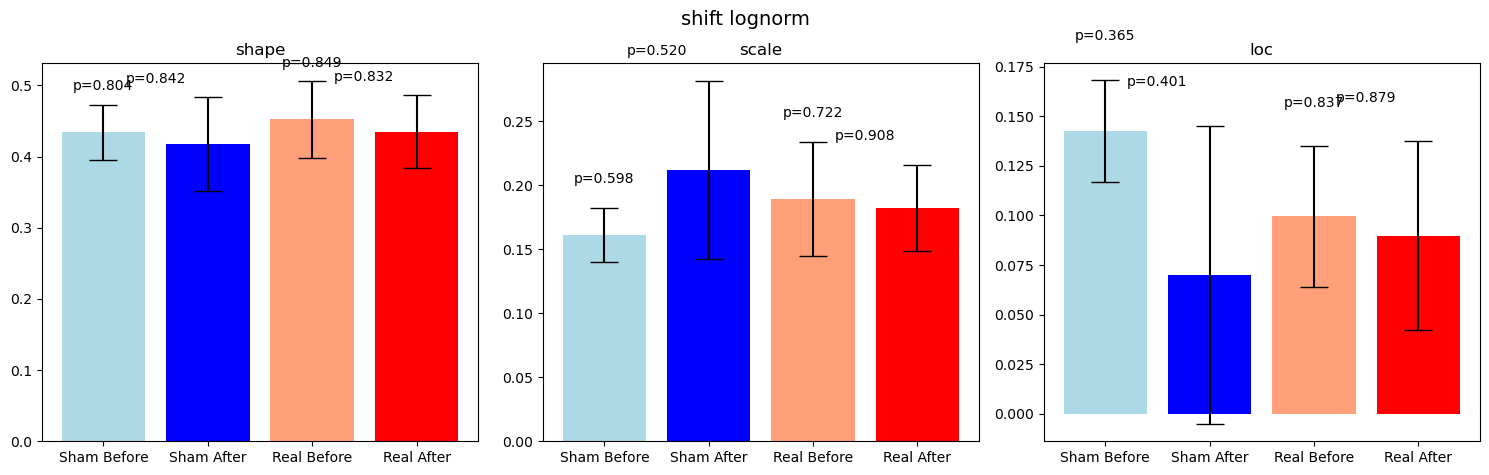

In [42]:
case = 'all'
p_method = 'utest'
session_name = ['before', 'after']
methods_name = ['shift lognorm', 'exgaussian', 'ddm', 'shift invgauss']
group_name = ['sham', 'real']
method_params = [3, 3, 4, 3]
param_names = [['shape', 'scale', 'loc'],['shape', 'loc', 'scale'],['Drift', 'Noise', 'Bound', 'Overlay'],['shape', 'loc', 'scale']]
param_meaning = [['Difficulty', 'Scale', 'Shift'], ['Center', 'Scale', 'Messy'], ['Difficulty', 'Difficulty', 'Difficulty', 'Onset'], ['Difficulty', 'Onset', 'Scale']]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 3 subplots in a row

for param_idx, param_name in enumerate(param_names[0]):

    roi_lines = param_record.loc[(param_record['case'] == case) & (param_record['method'] == methods_name[0]) 
                                & (param_record['group'] == 'sham') & (param_record['session'] == 'before'), 'params']
    sham_before =  [float(x.split(',')[param_idx].strip('[]')) for x in roi_lines.astype(str)]

    roi_lines = param_record.loc[(param_record['case'] == case) & (param_record['method'] == methods_name[0]) 
                                & (param_record['group'] == 'sham') & (param_record['session'] == 'after'), 'params']
    sham_after =  [float(x.split(',')[param_idx].strip('[]')) for x in roi_lines.astype(str)]

    roi_lines = param_record.loc[(param_record['case'] == case) & (param_record['method'] == methods_name[0]) 
                                & (param_record['group'] == 'real') & (param_record['session'] == 'before'), 'params']
    real_before =  [float(x.split(',')[param_idx].strip('[]')) for x in roi_lines.astype(str)]

    roi_lines = param_record.loc[(param_record['case'] == case) & (param_record['method'] == methods_name[0]) 
                                & (param_record['group'] == 'real') & (param_record['session'] == 'after'), 'params']
    real_after =  [float(x.split(',')[param_idx].strip('[]')) for x in roi_lines.astype(str)]

        # Compute means and standard errors
    means = [np.mean(sham_before), np.mean(sham_after), np.mean(real_before), np.mean(real_after)]
    std_errors = [np.std(data)/np.sqrt(len(data)) for data in [sham_before, sham_after, real_before, real_after]]
    
    # Calculate t-tests
    _, p_val_sham = ttest_ind(sham_before, sham_after)
    _, p_val_real = ttest_ind(real_before, real_after)
    _, p_val_before = ttest_ind(sham_before, real_before)
    _, p_val_after = ttest_ind(sham_after, real_after)

    # Plotting
    labels = ['Sham Before', 'Sham After', 'Real Before', 'Real After']
    colors = ['lightblue', 'blue', 'lightsalmon', 'red']
    
    bars = axs[param_idx].bar(labels, means, yerr=std_errors, color=colors, capsize=10)
    axs[param_idx].set_title(param_name)

    # Add p-values to the subplot
    heights = [bar.get_height() + error for bar, error in zip(bars, std_errors)]
    axs[param_idx].text(0.5, heights[1] + 0.02, f'p={p_val_sham:.3f}', ha='center')
    axs[param_idx].text(2.5, heights[3] + 0.02, f'p={p_val_real:.3f}', ha='center')
    axs[param_idx].text(0.0, heights[0] + 0.02, f'p={p_val_before:.3f}', ha='center')
    axs[param_idx].text(2.0, heights[2] + 0.02, f'p={p_val_after:.3f}', ha='center')

plt.suptitle('shift lognorm', y=0.94, fontsize=14)
plt.tight_layout()
plt.show()



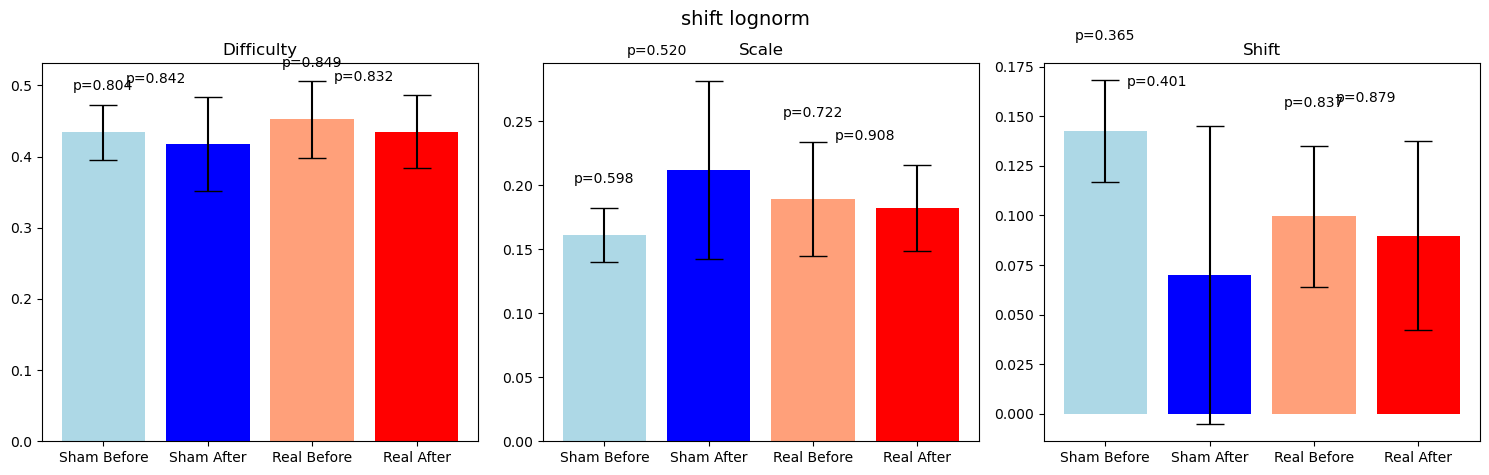

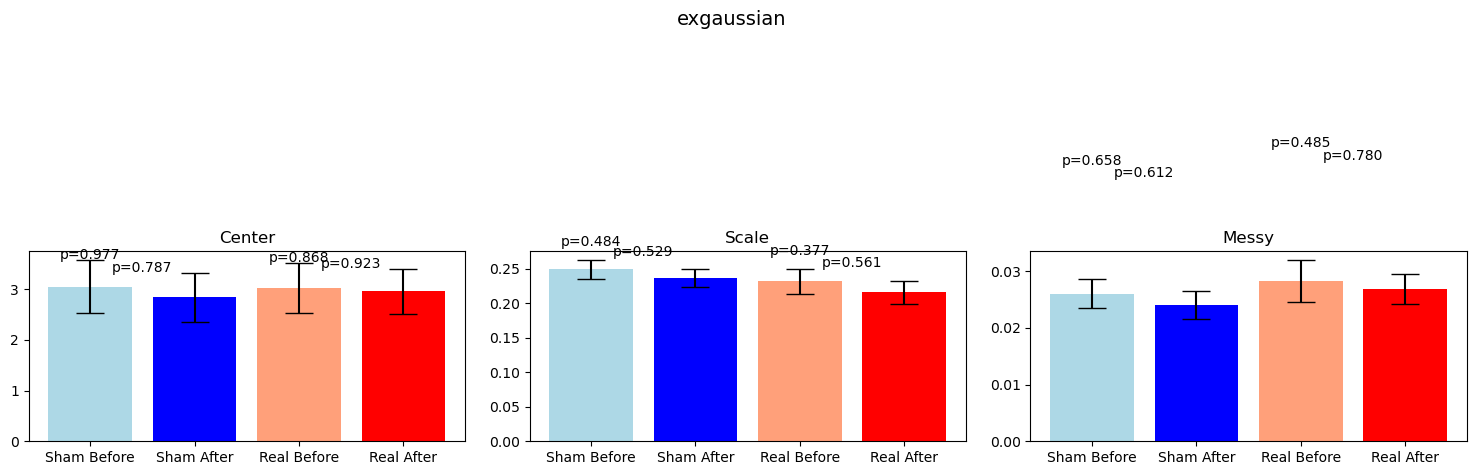

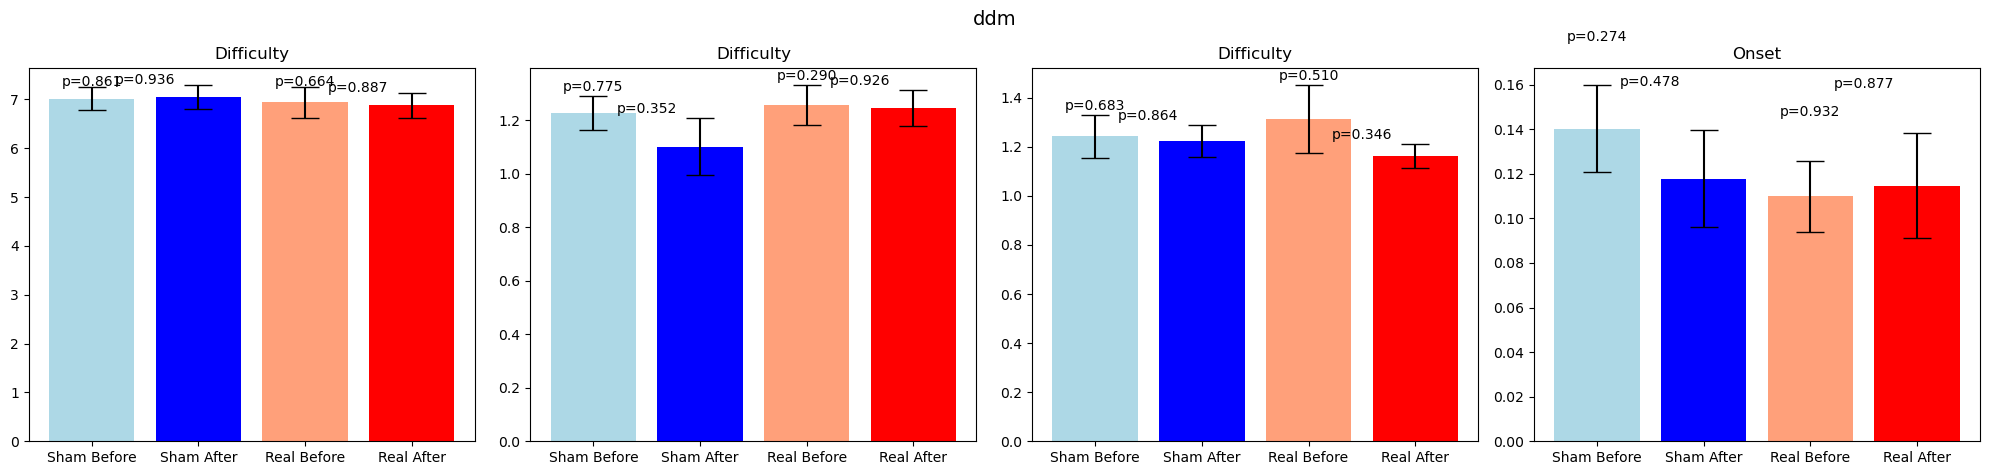

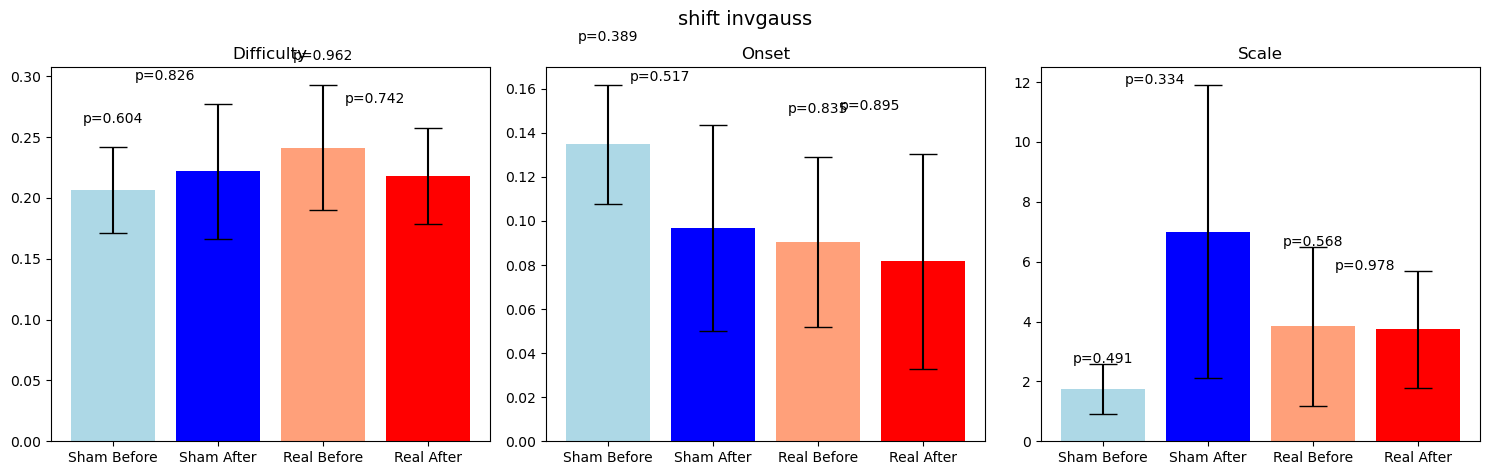

In [46]:
case = 'all'
p_method = 'utest'
session_name = ['before', 'after']
methods_name = ['shift lognorm', 'exgaussian', 'ddm', 'shift invgauss']
group_name = ['sham', 'real']
method_params = [3, 3, 4, 3]
param_names = [['shape', 'scale', 'loc'],['shape', 'loc', 'scale'],['Drift', 'Noise', 'Bound', 'Overlay'],['shape', 'loc', 'scale']]
param_meaning = [['Difficulty', 'Scale', 'Shift'], ['Center', 'Scale', 'Messy'], ['Difficulty', 'Difficulty', 'Difficulty', 'Onset'], ['Difficulty', 'Onset', 'Scale']]

for method_idx, method in enumerate(methods_name):
    param_num = method_params[method_idx]
    fig, axs = plt.subplots(1, param_num, figsize=(5*param_num, 5))  # n subplots in a row

    for param_idx, param_name in enumerate(param_meaning[method_idx]):

        roi_lines = param_record.loc[(param_record['case'] == case) & (param_record['method'] == method) 
                                    & (param_record['group'] == 'sham') & (param_record['session'] == 'before'), 'params']
        sham_before =  [float(x.split(',')[param_idx].strip('[]')) for x in roi_lines.astype(str)]

        roi_lines = param_record.loc[(param_record['case'] == case) & (param_record['method'] == method) 
                                    & (param_record['group'] == 'sham') & (param_record['session'] == 'after'), 'params']
        sham_after =  [float(x.split(',')[param_idx].strip('[]')) for x in roi_lines.astype(str)]

        roi_lines = param_record.loc[(param_record['case'] == case) & (param_record['method'] == method) 
                                    & (param_record['group'] == 'real') & (param_record['session'] == 'before'), 'params']
        real_before =  [float(x.split(',')[param_idx].strip('[]')) for x in roi_lines.astype(str)]

        roi_lines = param_record.loc[(param_record['case'] == case) & (param_record['method'] == method) 
                                    & (param_record['group'] == 'real') & (param_record['session'] == 'after'), 'params']
        real_after =  [float(x.split(',')[param_idx].strip('[]')) for x in roi_lines.astype(str)]

        # Compute means and standard errors
        means = [np.mean(sham_before), np.mean(sham_after), np.mean(real_before), np.mean(real_after)]
        std_errors = [np.std(data)/np.sqrt(len(data)) for data in [sham_before, sham_after, real_before, real_after]]
        
        # Calculate t-tests
        _, p_val_sham = ttest_ind(sham_before, sham_after)
        _, p_val_real = ttest_ind(real_before, real_after)
        _, p_val_before = ttest_ind(sham_before, real_before)
        _, p_val_after = ttest_ind(sham_after, real_after)

        # Plotting
        labels = ['Sham Before', 'Sham After', 'Real Before', 'Real After']
        colors = ['lightblue', 'blue', 'lightsalmon', 'red']
        
        bars = axs[param_idx].bar(labels, means, yerr=std_errors, color=colors, capsize=10)
        axs[param_idx].set_title(param_name)

        # Add p-values to the subplot
        heights = [bar.get_height() + error for bar, error in zip(bars, std_errors)]
        axs[param_idx].text(0.5, heights[1] + 0.02, f'p={p_val_sham:.3f}', ha='center')
        axs[param_idx].text(2.5, heights[3] + 0.02, f'p={p_val_real:.3f}', ha='center')
        axs[param_idx].text(0.0, heights[0] + 0.02, f'p={p_val_before:.3f}', ha='center')
        axs[param_idx].text(2.0, heights[2] + 0.02, f'p={p_val_after:.3f}', ha='center')

    plt.suptitle(method, y=0.94, fontsize=14)
    plt.tight_layout()
    plt.show()